# Data Lab 4

Predicting climate 3-month averages (precipitation, near-surface temperature) from the ENSO state

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Indonesia precipitation example

Predicting JJA Indonesia precipitation from ENSO state.

The conditional distribution aka "forecast distribution" 

$$ p(y | x) $$

- $y$ is Indonesia precipitation
- $x$ 
    - categorical: cool, neutral, warm Nino 3.4 based on terciles
    - Nino 3.4 value

Forecast formats
- single number
- Prediction interval
- Prob. of above, middle, below rainfall categories

Training data: 1979 - 2019

Test data: 2020


## 1. Read data

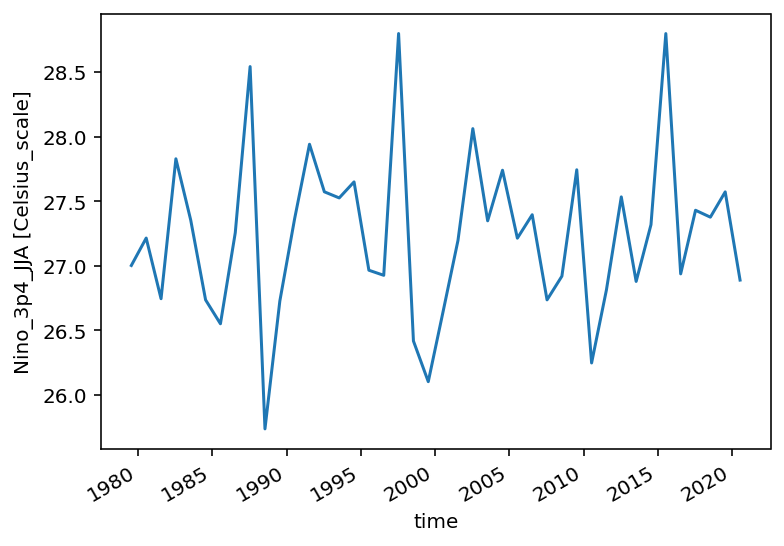

In [2]:
# Read JJA Nino 3.4
n34_JJA_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_JJA/dods'
n34_JJA_ds = xr.open_dataset(n34_JJA_url)
n34_JJA = n34_JJA_ds.n34_JJA
n34_JJA.plot();

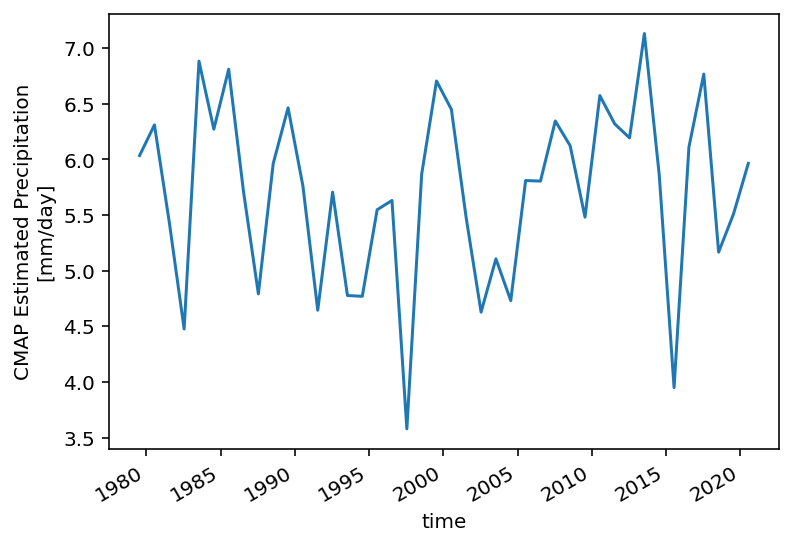

In [3]:
# Read Indonesia region rainfall
indo_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.indonesia_prcp_JJA/dods'
indo_ds = xr.open_dataset(indo_url)
prcp_indo = indo_ds.indonesia_prcp_JJA
prcp_indo.plot();

### 1.1 Withhold the final value (this year)

In [4]:
# Develop our prediction on all the values up to this year and then predict this year's value from xp
x = n34_JJA[0:-1].values
xp = n34_JJA[-1].values # this year
y = indo_ds.indonesia_prcp_JJA[:-1].values
yp = indo_ds.indonesia_prcp_JJA[-1].values

### 1.2 Define Nino 3.4 and precipitation terciles

In [5]:
# Define warm and cool ENSO categories
xm = x.mean()
xa = x - xm

thresholds = np.quantile(xa, np.array([1./3., 2./3.]))
t_nina = xa <= thresholds[0]
t_nino = xa >= thresholds[1]
t_neut = ~(t_nina | t_nino)

y_thresholds = np.quantile(y, np.array([1./3., 2./3.]))

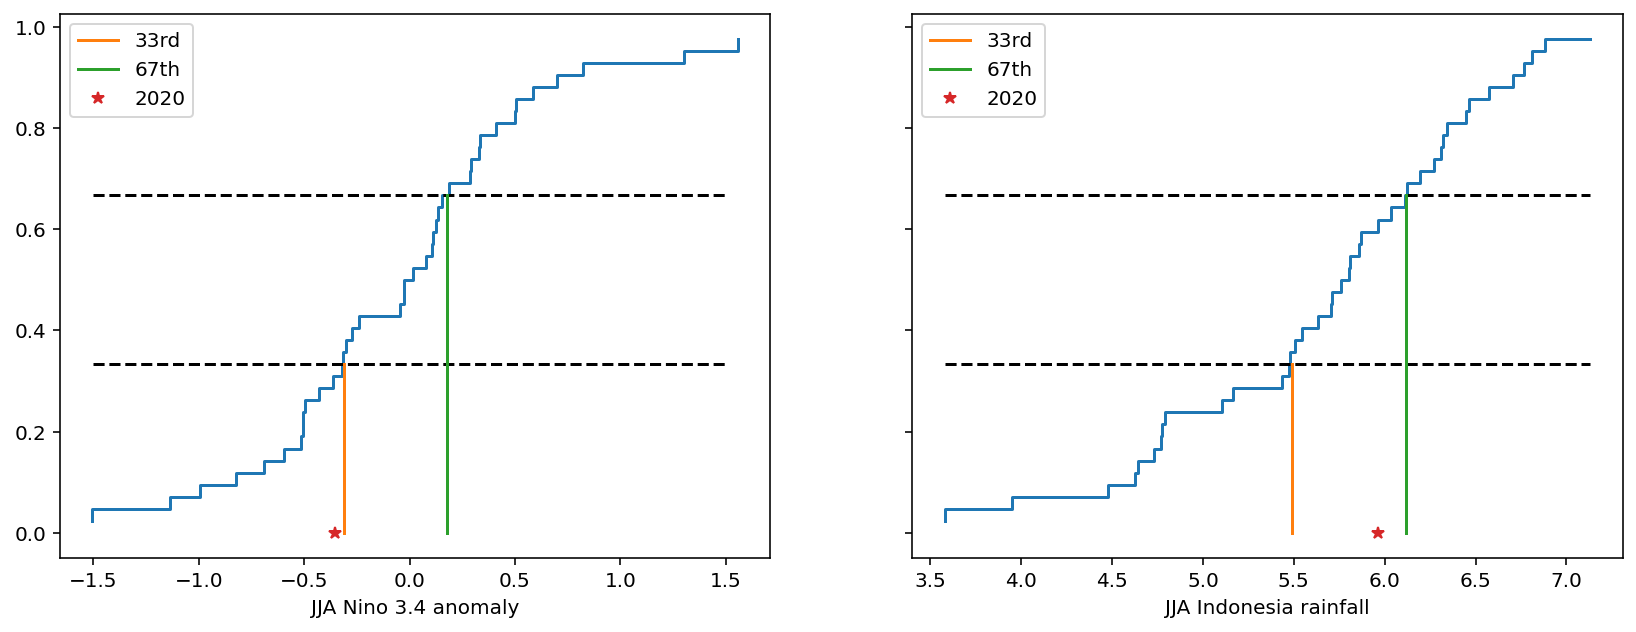

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(14,5), sharey=True)

ax = axs[0]
ax.step(np.sort(xa), np.arange(1,41 + 1)/(41 + 1))
ax.plot(np.array([-1.5,1.5]), 1./3.*np.array([1,1]), 'k--')
ax.plot(np.array([-1.5,1.5]), 2./3.*np.array([1,1]), 'k--')
ax.plot(thresholds[0]*np.array([1, 1]), np.array([0, 1./3.]), label = '33rd')
ax.plot(thresholds[1]*np.array([1, 1]), np.array([0, 2./3.]), label = '67th')
ax.plot(xp - xm, 0, '*', label = '2020')
ax.set_xlabel('JJA Nino 3.4 anomaly');
ax.legend()

ax = axs[1]
ax.step(np.sort(y), np.arange(1,41 + 1)/(41 + 1))
x_range = np.array([y.min(),y.max()])
ax.plot(x_range, 1./3.*np.array([1,1]), 'k--')
ax.plot(x_range, 2./3.*np.array([1,1]), 'k--')
ax.plot(y_thresholds[0]*np.array([1, 1]), np.array([0, 1./3.]), label = '33rd')
ax.plot(y_thresholds[1]*np.array([1, 1]), np.array([0, 2./3.]), label = '67th')
ax.plot(yp, 0, '*', label = '2020')
ax.set_xlabel('JJA Indonesia rainfall');
ax.legend();

### 1.3 Make forecasts based on the JJA Nino 3.4 category

In [7]:
# Point estimate
y_forecast = np.mean(y[t_nina])
print('Forecast total = {:4.2f} mm/day'.format(y_forecast))
print('Forecast anomaly = {:4.2f} mm/day'.format(y_forecast - y.mean()))

Forecast total = 6.29 mm/day
Forecast anomaly = 0.59 mm/day


In [8]:
# Prediction interval
pi_80 = np.quantile(y[t_nina], [0.10, 0.90])
print('80% of the time during La Nina, JJA rainfall totals have been in the range', pi_80)
print('80% of the time during La Nina, JJA rainfall anomalies have been in the range', pi_80 - y.mean())

80% of the time during La Nina, JJA rainfall totals have been in the range [5.70192914 6.77854986]
80% of the time during La Nina, JJA rainfall anomalies have been in the range [0.00279527 1.07941599]


In [9]:
# Probability forecasts
P_above = np.mean( y[t_nina] > y_thresholds[1])
P_below = np.mean( y[t_nina] < y_thresholds[0])

print('Probability of prcp in the above category {:.1f}%'.format(100*P_above))
print('Probability of prcp in the neutral category {:.1f}%'.format(100*(1 - P_above - P_below)))
print('Probability of prcp in the below category {:.1f}%'.format(100*P_below))

Probability of prcp in the above category 71.4%
Probability of prcp in the neutral category 21.4%
Probability of prcp in the below category 7.1%


### 2. $K$-nearest neighbors: Predict rainfall based on the *value* of JJA Nino 3.4.

We cannot sample from $p(y|x)$ because

In [10]:
np.sum(x == xp)

0

But we can sample from $p(y|X \text{ is close to } x)$. We'd have to define close and that might depend on the value of $x$.

Alternatively we can use the $K$ data closest to $x$. What value should we choose for $K$? Not too big and not too small. $K=10$?

In [11]:
K = 10
knn = np.argsort( (x - xp)**2)
knn = knn[:K]

### 2.1 Make forecasts 

In [12]:
# Point estimate
y_forecast = np.mean(y[knn])
print('Forecast total = {:4.2f} mm/day'.format(y_forecast))
print('Forecast anomaly = {:4.2f} mm/day'.format(y_forecast - y.mean()))

Forecast total = 6.09 mm/day
Forecast anomaly = 0.40 mm/day


In [13]:
# Prediction interval
pi_80 = np.quantile(y[knn], [0.10, 0.90])
print('80% of the JJA rainfall totals were in the range', pi_80)
print('80% of the JJA rainfall anomalies were in the range', pi_80 - y.mean())

80% of the JJA rainfall totals were in the range [5.53616681 6.42385831]
80% of the JJA rainfall anomalies were in the range [-0.16296706  0.72472444]


In [14]:
# Probability forecasts
P_above = np.mean( y[knn] > y_thresholds[1])
P_below = np.mean( y[knn] < y_thresholds[0])

print('Probability of prcp in the above category {:4.1f}%'.format(100*P_above))
print('Probability of prcp in the neutral category {:4.1f}%'.format(100*(1 - P_above - P_below)))
print('Probability of prcp in the below category {:4.1f}%'.format(100*P_below))

Probability of prcp in the above category 50.0%
Probability of prcp in the neutral category 40.0%
Probability of prcp in the below category 10.0%


Need an objective way of choosing $K$. Cross-validation is one approach. https://en.wikipedia.org/wiki/Cross-validation_(statistics)

KNN is based on $E[y|x]$ being a constant in a neighborhood of $x$.

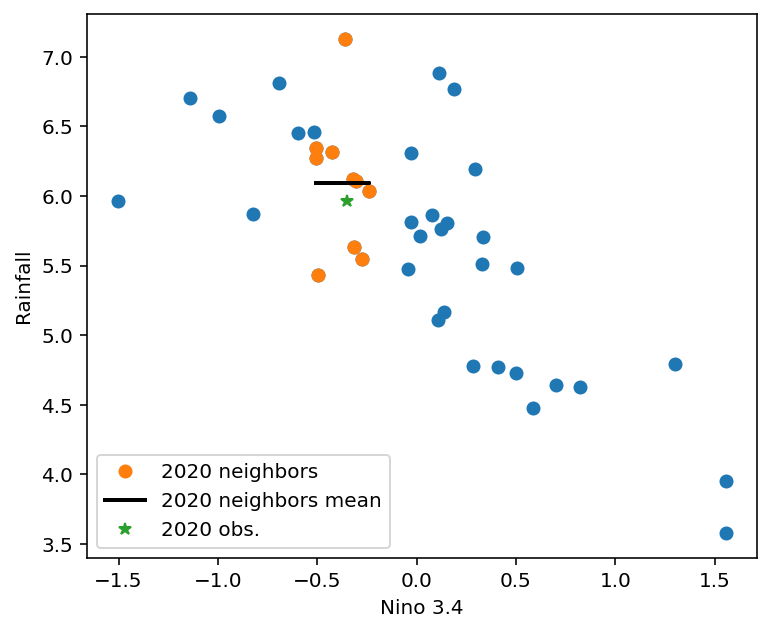

In [15]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(xa, y, 'o');
ax.set_xlabel('Nino 3.4')
ax.set_ylabel('Rainfall');

ax.plot(xa[knn], y[knn],'o', label='2020 neighbors')
ax.plot(xa[knn], y[knn].mean() + np.zeros_like(y[knn]), 'k', linewidth=2, label='2020 neighbors mean')
ax.plot(xp - xm, yp, '*', label = '2020 obs.')

ax.legend();

### 3. Linear regression: Predict rainfall based on the *value* of JJA Nino 3.4.

Linear regression takes $ E[ y | x ]$ to be a linear function of $x$ everywhere:

$$ E(\text{rainfall } | \text{ Nino 3.4} = x ) = ax + b $$

Estimate $a$ and $b$ by least squares. Make a forecast (single number)

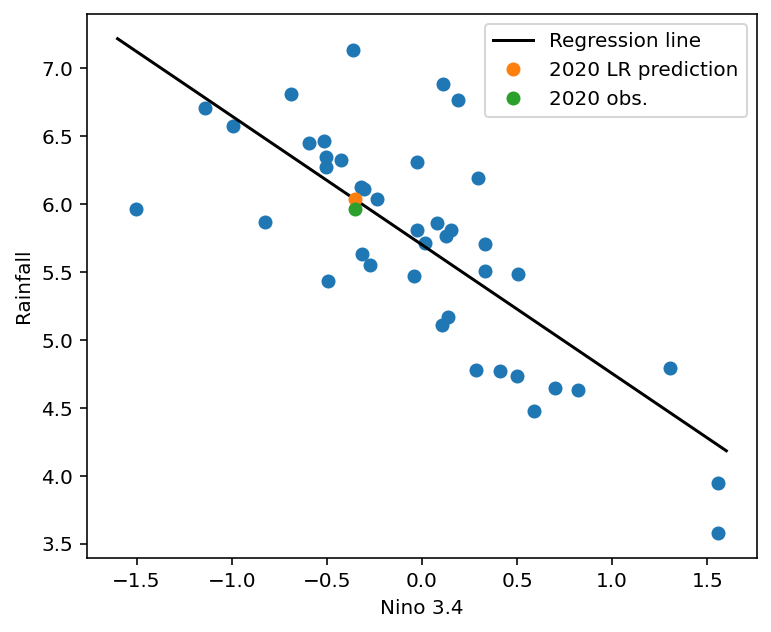

In [16]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(xa, y, 'o');
ax.set_xlabel('Nino 3.4')
ax.set_ylabel('Rainfall');

from numpy.linalg import inv

Nx = len(xa)
X = np.empty((Nx,2))
X[:,0] = xa #<-------------------------------------------compare to below
X[:,1] = 1
beta = inv(X.T@X)@X.T@y
yhat = X@beta

y_forecast_LR = beta[0]*(xp -xm) + beta[1] 

x_line = np.linspace(-1.6, 1.6)
ax.plot(x_line, beta[0]*x_line + beta[1], 'k', label = 'Regression line');
ax.plot(xp - xm, y_forecast_LR, 'o', label = '2020 LR prediction')
ax.plot(xp - xm, yp, 'o', label = '2020 obs.')

ax.legend();

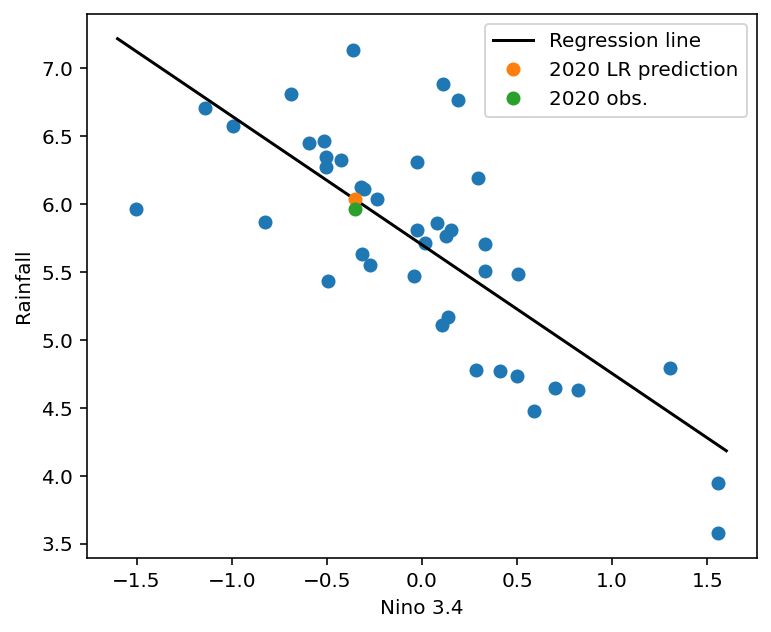

In [17]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(xa, y, 'o');
ax.set_xlabel('Nino 3.4')
ax.set_ylabel('Rainfall');

from numpy.linalg import inv

Nx = len(xa)
X = np.empty((Nx,2))
X[:,0] = x #<-------------------------------------------compare to above
X[:,1] = 1
beta = inv(X.T@X)@X.T@y
yhat = X@beta

y_forecast_LR = beta[0]*(xp) + beta[1] 

x_line = np.linspace(-1.6, 1.6)
ax.plot(x_line, beta[0]*(x_line + xm) + beta[1], 'k', label = 'Regression line');
ax.plot(xp - xm, y_forecast_LR, 'o', label = '2020 LR prediction')
ax.plot(xp - xm, yp, 'o', label = '2020 obs.')

ax.legend();

## Exercises

### Problem 1 
(10 points) Show that the function $g(x)$ that minimizes $E[ (Y - g(x))^2 | X = x]$ is $g(x) = E[Y | X=x]$.  
HINT: As a warm-up, first show that the constant $c$ that minimizes $E[(y-c)^2]$ is $c = E[y]$ without using calculus.  
Look at the terms that come out of $E[(y-\mu_Y + \mu_Y - c)^2]$.

$$
    \frac{d}{dx} E[(Y - g(x))^{2}|X=x] = \frac{d}{dx}\int^{\infty}_{-\infty} (y - g(x))^{2}p(y|x) dy = \int^{\infty}_{-\infty} -2(y - g(x))p(y| x)dy = -2\int^{\infty}_{-\infty} yp(y|x)dy + 2\int^{\infty}_{-\infty} g(x)p(y|x)dy = -2(E[Y|X=x] - g(x))
$$

Therefore, in order to mimimize this expectation, we would want to set $\boxed{g(x) = E[Y|X=x]}$

Hint warm-up: 

$$
    E[(y-c)^{2}] = E[(y - \mu_{Y} + \mu_{Y} - c)^{2}] = E[(y - \mu_{Y})^{2}] + E[(\mu_{Y} - c)^{2}]
$$

Not sure where to go with this. 

### Problem 2
(10 points) Suppose that $\hat{\mu}_{Y|x}$ is the average of $N$ independent samples from $p(y|x)$.  
Show that $E[ Y - \hat{\mu}_{Y|x} | X = x] = 0$ and that
$$ E[ (Y - \hat{\mu}_{Y|x})^2 | X = x] = \sigma_{Y|x}^2 \left(1 + \frac{1}{N} \right) \,.$$  
HINT What is the variance of the sample mean?
Forecast error is due to randomness and error in the estimate of the conditional mean.

$$
    E[Y - \hat{\mu}_{Y|x}|X = x] = E[Y|X=x] - E[\hat{\mu}_{Y|x}|X=x] = \hat{\mu}_{Y|x} - \hat{\mu}_{Y|x} = 0 
$$

$$
$$

$$
    E[ (Y - \hat{\mu}_{Y|x})^2 | X = x] = E[(Y - \bar{Y} + \bar{Y} - \hat{\mu}_{Y|x} )^{2}|X=x] = E[(Y - \bar{Y})^{2}|X=x] + E[(\bar{Y} - \hat{\mu}_{Y|x})^{2}|X=x]
$$
$$
    = \sigma^{2}_{Y|x} + \sigma_{m}^{2} = \sigma^{2}_{Y|x} + \frac{\sigma^{2}_{Y|x}}{N} = \sigma^{2}_{Y|x} \bigg(1 + \frac{1}{N}\bigg)
$$


### Problem 3 
(10 points) Compute a 95% confidence interval for the mean of JJA Indonesian rainfall during cool and warm conditions 1979-2019. 
(Reminder how here https://en.wikipedia.org/wiki/Student%27s_t-distribution#How_Student's_distribution_arises_from_sampling)
Add it to the code below to produce the figure. 
<div>
<img src="images/Indonesia_JJA_rainfall_Nino3p4.png" width="600"/>
</div>

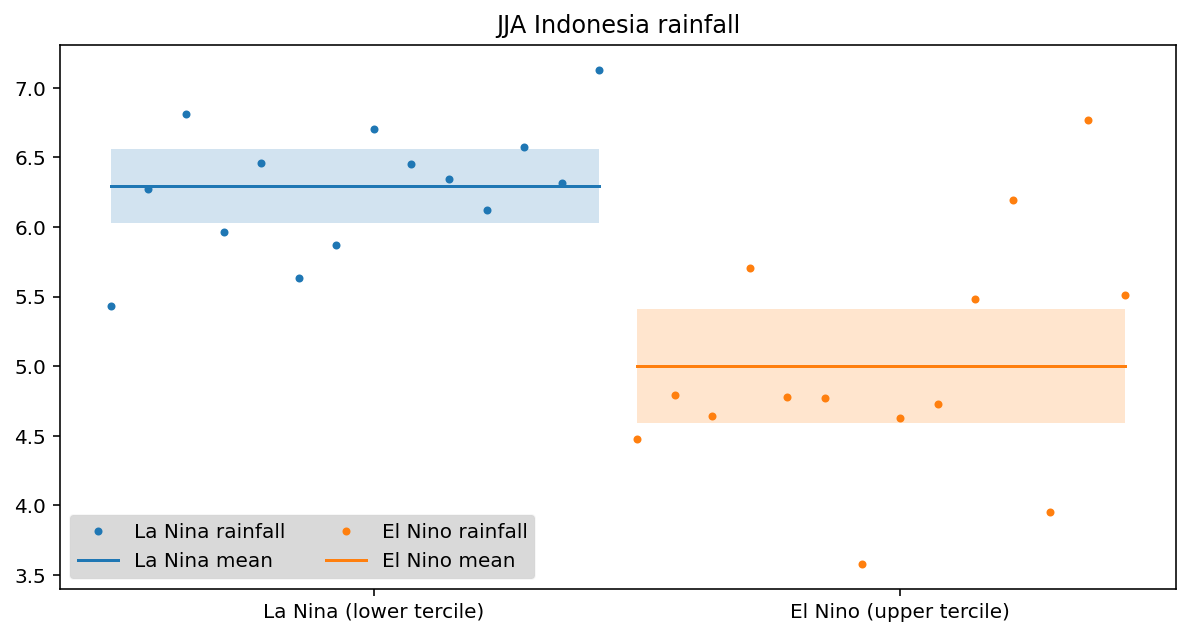

In [18]:
ci = np.nan

N1 = np.count_nonzero(t_nina)
N2 = np.count_nonzero(t_nino)

s1 = np.arange(0,N1)
s2 = np.arange(0,N2)

fig, ax = plt.subplots(figsize = (10, 5))

alpha = 0.95

ax.plot(s1, y[t_nina], '.', label = 'La Nina rainfall')
ax.plot(s1, y[t_nina].mean() + 0.0*s1, color=colors[0], label = 'La Nina mean')
t = stats.t.ppf(alpha, df=N1-1, loc = y[t_nina].mean())
ci = t * stats.sem(y[t_nina]) / np.sqrt(N1)
ax.fill_between(s1, y[t_nina].mean() - ci + 0.0*s1, y[t_nina].mean() + ci + 0.0*s1, alpha = 0.2) 

ax.plot(s2 + N1, y[t_nino], '.', label = 'El Nino rainfall')
ax.plot(s2 + N1, y[t_nino].mean() + 0.0*s2, color=colors[1], label = 'El Nino mean')
t = stats.t.ppf(alpha, df=N2-1, loc = y[t_nino].mean())
ci = t * stats.sem(y[t_nino]) / np.sqrt(N2)
ax.fill_between(s2 + N1, y[t_nino].mean() - ci + 0.0*s2, y[t_nino].mean() + ci + 0.0*s2, alpha = 0.2)
ax.set_xticks([])

ax.legend(ncol = 2, framealpha = 0.15, facecolor = 'k', loc = 'lower left');
ax.set_title('JJA Indonesia rainfall');
plt.xticks([N1/2, 3*N2/2],['La Nina (lower tercile)', 'El Nino (upper tercile)']);
# Shading is CI for mean

### Problem 4 
(10 points) Choose $K$ in K-nearest neighbors by finding the value of $K$ whose leave-one-out cross-validated (CV) mean-squared error (MSE) is smallest. Below is starter code.
    - Add comments explaining what the code does. 
    - The 2D array `y_hat` contains forecasts with each column being a different year and each row using a different value of $K$.
    - Compute the error by subtracting $y$. Broadcasting is your friend.
    - Square and average over years to get the mean squared error as function of $K$.  
    - Plot the MSE as a function of $K$.
    
(The interval is a so-called 1$\sigma$ interval.)  
MSE = mean(squared error)  
$\sigma$ = std(squared error)/sqrt(sample size)
    

In [19]:
kmax = len(x) - 1 # Setting Number of K value
y_hat = np.empty((kmax, len(x))) # Setting up an empty matrix with len(x) columns for years and kmax rows for K-values 
for ii in range(0, len(x)): # looping through values of ii from 0 to len(x) - 1
    leave_1_out = list(range(0, len(x))) # Creates list from 0 to len(x) - 1
    leave_1_out.remove(ii) # Takes out the point ii from the list 
    x1 = x[leave_1_out] # Pulls out all the values of x that correspond to the every index except ii 
    y1 = y[leave_1_out] # Pulls out all the values of y that correspond to the every index except ii
    knn1 = np.argsort( (x1 - x[ii])**2) # Creates an array of sorted indices of (x1 - x[ii])**2, where x[ii] is the missing value from x1
    for k in range(1,kmax + 1): # Loops through the k-values in knn1
        knn0 = knn1[:k] # Sets up an array of indices from knn1 from the 0th index to the kth index
        y_hat[k - 1, ii] = y1[knn0].mean() # Set up y_hat value at row k-1, column ii, that is the mean corresponding the the k value for a certain year. 

In [26]:
# Compute the error 
error = np.subtract(y, y_hat)

# Square and average over the years to get the MSE as function of K 
se = np.square(error)
mse = np.mean(se)

print("MSE: ", mse)

MSE:  0.4556541262787298


### Problem 5
(30 points) Look at the Oceanic Nino Index (ONI) values here https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php
    - Which winters since 2010 had cool ONI conditions?
    - Find the NOAA winter precipitation outlooks for those years and include them below. Here is the one for the winter of 2017-2018
      <div>
      <img src="https://www.climate.gov/sites/default/files/PrecipitationOutlook_Winter2017_620.png" width="400"/>
      </div>
    - Use the code below to read the Aug Nino 3.4 values from 1979 through 2020.
        - Find the 10 years with Aug Nino 3.4 values closest to that of 2020.
    - Use the code below to read the Dec-Feb (DJF) North America precipitation data for Dec 1979 - Feb 1980 though Dec 2019 - Feb 2020 (last winter). (The time coordinate of the precipitaion is the middle month (Jan) of the 3-month period.)
     - Use KNN with $K=10$ to
         - forecast the DJF precipitation (single map) 
         - Compute an 80% prediction interval (2 maps)
         - Compute the probability of the DJF precipitation being in the below, middle, and above terciles (3 maps)

**Boreal winters since 2010 that have had cool ONI conditions include 2010-2011, 2011-2012, 2016-2017, 2017-2018.**

NOAA Winter Preicipitation Outlooks for these years 

**Boreal Winter 2010-2011**
<div>
<img src="http://2.bp.blogspot.com/_oy2DMM6iwUU/TMCFsp7BvHI/AAAAAAAAB1s/S3X2iffrjIc/s320/cpc.winteroutlookprecip2_20102.jpg" width="400"/>
</div>

**Boreal Winter 2011-2012**
<div>
<img src="https://earthsky.org/upl/2011/10/NOAA-Winter-Outlook-Precipitation-2011-2012-e1319174652975.png" width="400"/>
</div>


**Boreal Winter 2016-2017**
<div>
<img src="https://www.noaa.gov/sites/default/files/thumbnails/image/GRAPHIC%20-%20Outlook_map_Precip_2016%20-%2010202016%20-%20NOAA%20-%20800x624%20-%20INSET.jpg" width="400"/>
</div>

**Boreal Winter 2017-2018**
<div>
<img src="https://www.climate.gov/sites/default/files/PrecipitationOutlook_Winter2017_620.png" width="400"/>
</div>

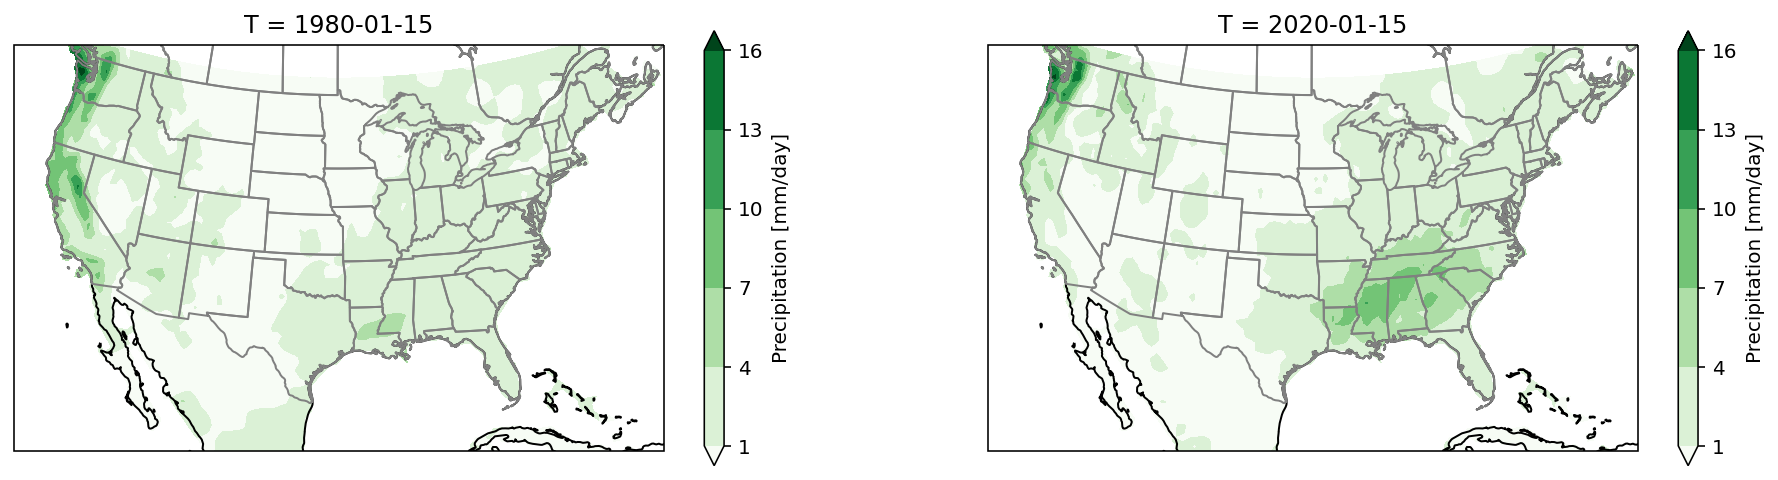

In [100]:
import matplotlib.colors as colors

prcp_DJF_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.prcp_DJF_NA/124/pop/dods'
prcp_DJF_ds = xr.open_dataset(prcp_DJF_url)
prcp = prcp_DJF_ds.prcp_DJF_NA
prcp.load()

# two-panel plot of the first and last values 
# This is a "fancy" plot showing some additional features
proj_map = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
proj_dta = ccrs.PlateCarree()  # the data's projection

fig = plt.figure(figsize=(16,4))
ax1 = plt.subplot(1,2,1,projection=proj_map)
ax2 = plt.subplot(1,2,2,projection=proj_map)

extent = [-120, -70, 20, 50.5]

prcp.isel(T = 0).plot.contourf(transform=proj_dta, ax = ax1, vmin=1, vmax=16, cmap='Greens', levels = 6)
ax1.coastlines();
ax1.add_feature(cfeature.STATES, edgecolor='gray')
ax1.set_extent(extent)

prcp.isel(T =-1).plot.contourf(transform=proj_dta, ax = ax2, vmin=1, vmax=16, cmap='Greens', levels = 6);
ax2.coastlines();
ax2.add_feature(cfeature.STATES, edgecolor='gray')
ax2.set_extent(extent)

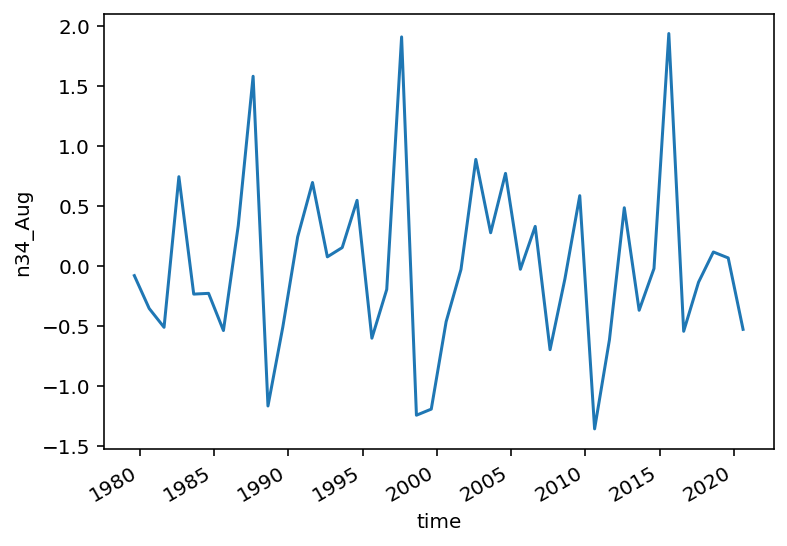

In [56]:
# Aug Nino 3.4 
n34_Aug_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_Aug/dods'
n34_Aug_ds = xr.open_dataset(n34_Aug_url)
n34_Aug = n34_Aug_ds.n34_Aug - n34_Aug_ds.n34_Aug.mean('T')
n34_Aug.plot();

### Find the 10 years with Aug Nino 3.4 values closest to that of 2020.

In [92]:
# Find the 10 years with Aug Nino 3.4 values closest to that of 2020.
k = 10 
n34_Aug_2020 = n34_Aug[-1]
n34_Aug_1978_2019 = n34_Aug[:-1]

knn1 = np.argsort( (n34_Aug_1978_2019 - n34_Aug_2020)**2 )
knn = knn1[:k]
knn_sort = np.sort(knn)

closest = n34_Aug_1978_2019[knn_sort]

print("10 years with Aug Nino 3.4 values closest to that of 2020: ", closest.coords['T'].values)

10 years with Aug Nino 3.4 values closest to that of 2020:  ['1980-08-17T00:00:00.000000000' '1981-08-17T12:00:00.000000000'
 '1985-08-17T12:00:00.000000000' '1989-08-17T12:00:00.000000000'
 '1995-08-17T12:00:00.000000000' '2000-08-17T00:00:00.000000000'
 '2007-08-17T12:00:00.000000000' '2011-08-17T12:00:00.000000000'
 '2013-08-17T12:00:00.000000000' '2016-08-17T00:00:00.000000000']


### forecast the DJF precipitation (single map)

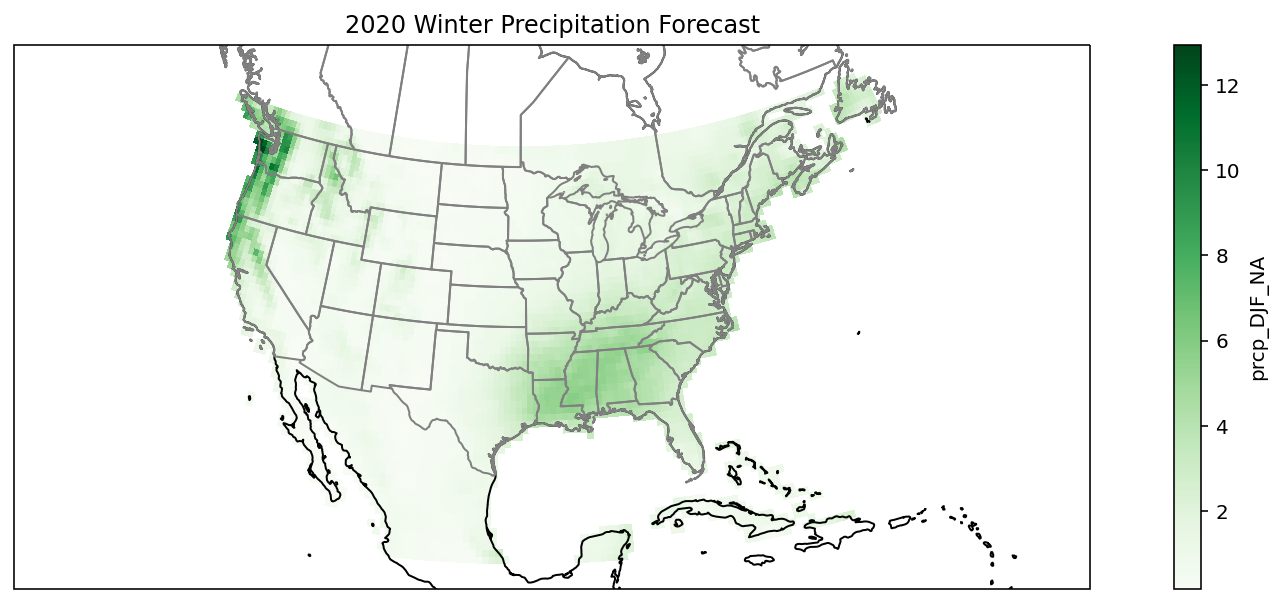

In [137]:
k = 10
prcp_2020 = prcp[-1]
prcp_1980_2019 = prcp[:-1]

se = (np.subtract(prcp_1980_2019,prcp_2020))**2
mse = se.mean(axis=(1,2))
knn1 = np.argsort(mse)
knn = knn1[:k]

knn_sort = np.sort(knn)

forecast = prcp_1980_2019[knn_sort].mean("T")

fig = plt.subplots(figsize=(15,5))
ax = plt.subplot(projection=proj_map)

forecast.plot(transform=proj_dta, ax = ax, cmap='Greens')
ax.coastlines();
ax.set_title('2020 Winter Precipitation Forecast')
ax.add_feature(cfeature.STATES, edgecolor='gray')


### Compute an 80% prediction interval (2 maps)

80% of the JJA rainfall totals were in the range [0.34658414 3.74095938]


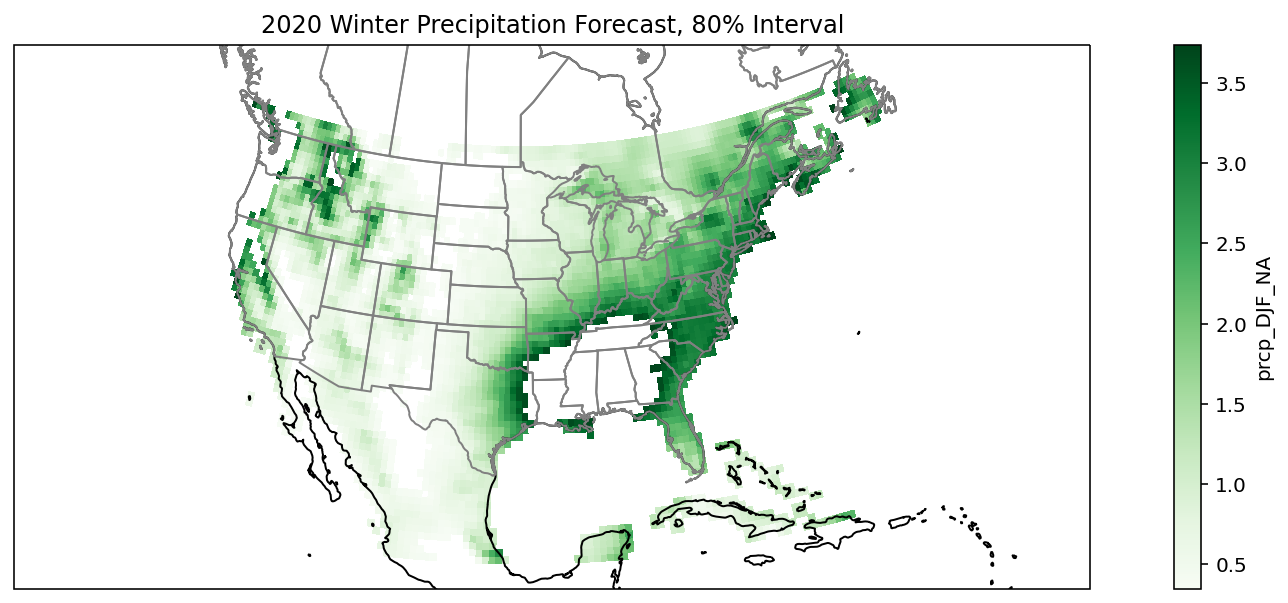

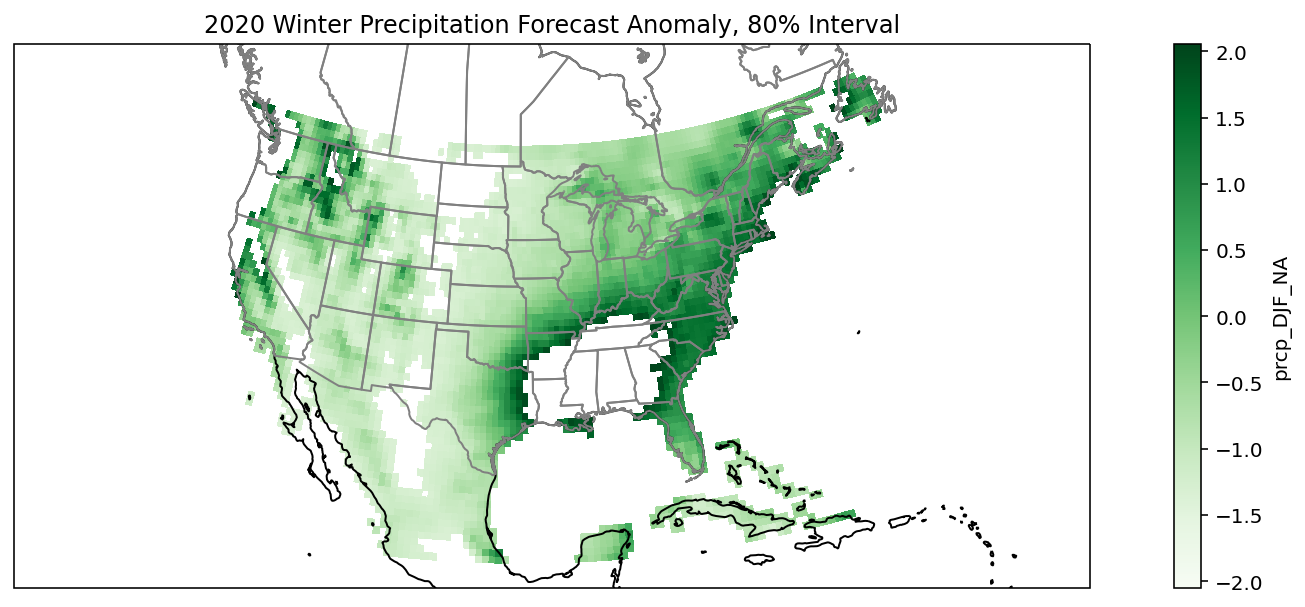

In [176]:
flat = forecast.stack(z=("X", "Y"))
pi_80 = np.quantile(flat.dropna("z"), [0.10, 0.90])

print('80% of the JJA rainfall totals were in the range', pi_80)
#print('80% of the JJA rainfall anomalies were in the range', pi_80 - y.mean())

fc_80 = forecast.where((forecast > pi_80[0]) & (forecast < pi_80[1]))

fig = plt.subplots(figsize=(15,5))
ax = plt.subplot(projection=proj_map)

fc_80.plot(transform=proj_dta, ax = ax, cmap='Greens')
ax.coastlines();
ax.set_title('2020 Winter Precipitation Forecast, 80% Interval')
ax.add_feature(cfeature.STATES, edgecolor='gray')

mean = forecast.mean()
mean = [mean]
np.subtract(pi_80, mean)

fc_80_anomaly = fc_80 - mean

fig = plt.subplots(figsize=(15,5))
ax = plt.subplot(projection=proj_map)

fc_80_anomaly.plot(transform=proj_dta, ax = ax, cmap='Greens')
ax.coastlines();
ax.set_title('2020 Winter Precipitation Forecast Anomaly, 80% Interval')
ax.add_feature(cfeature.STATES, edgecolor='gray')